In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys

sys.path.append('../')
from lobster import Lightcurve
from lobster.filtering import *

Fonction générale permettant de tester des fonctions de transfert quelconques.

In [2]:
def test_filter(
    filter_func,
    test_func=np.sin,
    N_freqs=2000,
    N_periods=25,
    resolution_times=5000,
    window_days_duration=10,
    ax=None,
    f_min=1e-9,
    f_max=1e-3,
    gain_mode="peak_to_peak",
    show_freq_for_gain=1.0,
    find_freq_ascending=True,
    minimum_gain=1e-14,
    visualisation="d",
    show_unitary_window=False,
    label=None,
):
    if 2 * N_periods >= resolution_times:
        print(
            f"warning: Shannon condition is not respected with {resolution_times} time bins and \
{N_periods} periods"
        )

    if gain_mode == "efficiency":
        calculate_gain = lambda e, s: np.sqrt(np.sum(s**2)) / np.sqrt(np.sum(e**2))
    elif gain_mode == "peak_to_peak":
        # get peak-to-peak gain, only taking the middle of the signal
        calculate_gain = lambda e, s: (
            np.max(s[len(s) // 4 : -len(s) // 4]) - np.min(s[len(s) // 4 : -len(s) // 4])
        ) / (np.max(e[len(e) // 4 : -len(e) // 4]) - np.min(e[len(e) // 4 : -len(e) // 4]))
    else:
        raise ValueError(f"could not find appropriate mode '{gain_mode}' for gain calculation")

    N_freqs = int(N_freqs)
    testing_freqs = np.logspace(np.log10(f_min), np.log10(f_max), N_freqs)
    bode = np.zeros(N_freqs)
    windows = np.zeros(N_freqs)

    for i, freq in enumerate(testing_freqs):
        freq_d = freq * (3600 * 24)
        testing_times = np.linspace(0, N_periods, resolution_times)
        e = test_func(2 * np.pi * testing_times)
        dt_days = 1 / (freq_d * resolution_times)
        window = int((window_days_duration / (N_periods * dt_days)) // 2 * 2 + 1)
        s = filter_func(e, window)
        gain = calculate_gain(e, s)
        windows[i] = window
        bode[i] = gain
        print(f"{(i+1)/len(testing_freqs)*100:.2f}%", end="\r")

    if ax is None:
        fig = plt.figure(figsize=(10, 6))
        ax = fig.add_subplot()
        ax.set_title("Frequency response in gain")
        ax.set_ylabel(r"Gain")
        ax.set_xscale("log")
        ax.set_yscale("log")
    else:
        fig = ax.get_figure()

    if visualisation == "Hz":
        ax.set_xlabel(r"Frequency ($\mu$Hz)")
        x_axis = testing_freqs * 1e6
    elif visualisation == "1/d":
        ax.set_xlabel(r"Frequency (d$^{-1}$)")
        x_axis = testing_freqs * 3600 * 24
    elif visualisation == "d":
        ax.set_xlabel(r"Period (d)")
        x_axis = 1 / (testing_freqs * 3600 * 24)
    else:
        raise ValueError(f"could not find appropriate visualisation mode '{visualisation}'")

    if show_unitary_window:
        ax.plot(
            x_axis[(bode > minimum_gain) & (window > 1)],
            bode[(bode > minimum_gain) & (window > 1)],
            alpha=0.8,
            label=label,
        )
        ax.fill_between(
            x_axis,
            0,
            1,
            where=windows == 1,
            transform=ax.get_xaxis_transform(),
            alpha=0.2,
            label=f"unitary window for {label}" if label else "unitary window",
        )
    else:
        ax.plot(x_axis[bode > minimum_gain], bode[bode > minimum_gain], alpha=0.8, label=label)

    if show_freq_for_gain:
        i_search_freq = 0 if find_freq_ascending else -1
        try:
            ax.axhline(y=show_freq_for_gain, c="green", lw=0.5, ls="--")
            index_gain = np.where(np.isclose(bode, show_freq_for_gain, atol=0.01))[0][i_search_freq]
            freq_gain = x_axis[index_gain]
            print(f"Gain of {show_freq_for_gain*100:.1f}% found for {freq_gain} {visualisation}")
            ax.axvline(x=freq_gain, c="green", lw=0.5, ls="--")
        except IndexError:
            pass

    ax.axhline(y=1, c="red", lw=0.5, ls="--")
    ax.legend()
    fig.tight_layout()
    return ax

Test des périodes de coupures des filtres en fonction de la taille de la fenêtre.

On utilise une fenêtre de 10 jour, donc 10 × "la période correspondant au gain trouvé" correspond à la quantité par laquelle il faut diviser une fenêtre quelconque pour la convertir en période de coupure du filtre.

Filtres testés (pour une réponse à 90%) :
- boxcar passe-bas → on divise par 3,87 environ
- triangulaire passe-bas → on divise par 2,72 environ
- sin4 passe-bas → on divise par 1,82 environ

Gain of 90.0% found for 38.65877947373639 d
Gain of 90.0% found for 27.17512811388451 d
Gain of 90.0% found for 18.200551869115763 d


<Axes: title={'center': 'Frequency response in gain'}, xlabel='Period (d)', ylabel='Gain'>

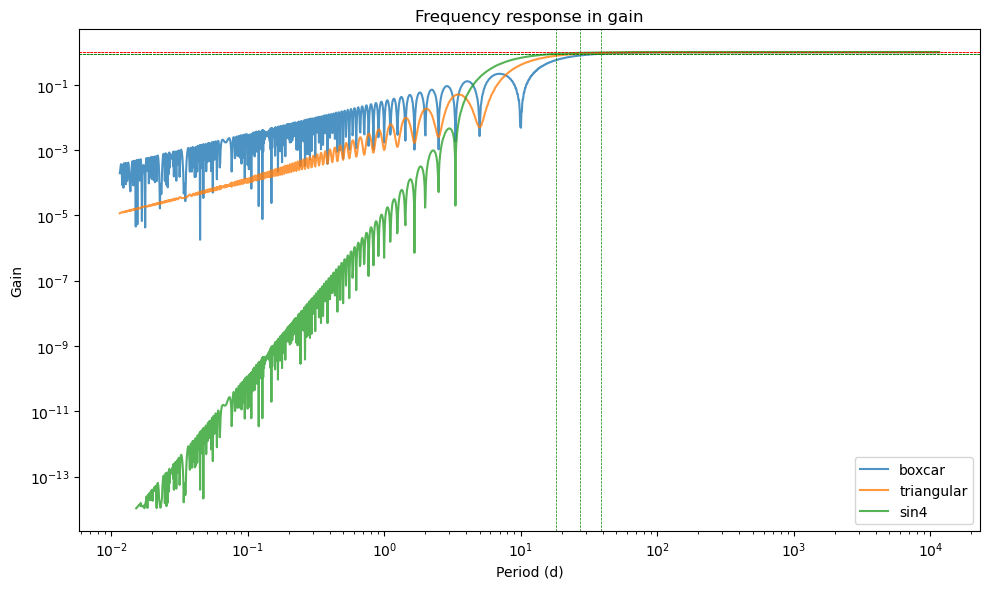

In [3]:
boxcar_passe_bas = lambda flux, window: boxcar_filter(flux, window)
triangulaire_passe_bas = lambda flux, window: triangular_filter(flux, window)
sin4_passe_bas = lambda flux, window: sin4_filter(flux, window)

test_func = lambda x: np.sin(x)

ax = test_filter(boxcar_passe_bas, test_func=test_func, label="boxcar", find_freq_ascending=False, show_freq_for_gain=.9)
test_filter(triangulaire_passe_bas, test_func=test_func, ax=ax, label="triangular", find_freq_ascending=False, show_freq_for_gain=.9)
test_filter(sin4_passe_bas, test_func=test_func, ax=ax, label="sin4", find_freq_ascending=False, show_freq_for_gain=.9)

Filtres testés (pour une réponse à 100%) :
- boxcar passe-haut → on divise par 1,000 environ
- triangulaire passe-haut → on divise par 0,532 environ
- sin4 passe-haut → on divise par 0,354 environ

Gain of 100.0% found for 10.045128393745696 d
Gain of 100.0% found for 5.3188460858676 d
Gain of 100.0% found for 3.537764167454171 d


<Axes: title={'center': 'Frequency response in gain'}, xlabel='Period (d)', ylabel='Gain'>

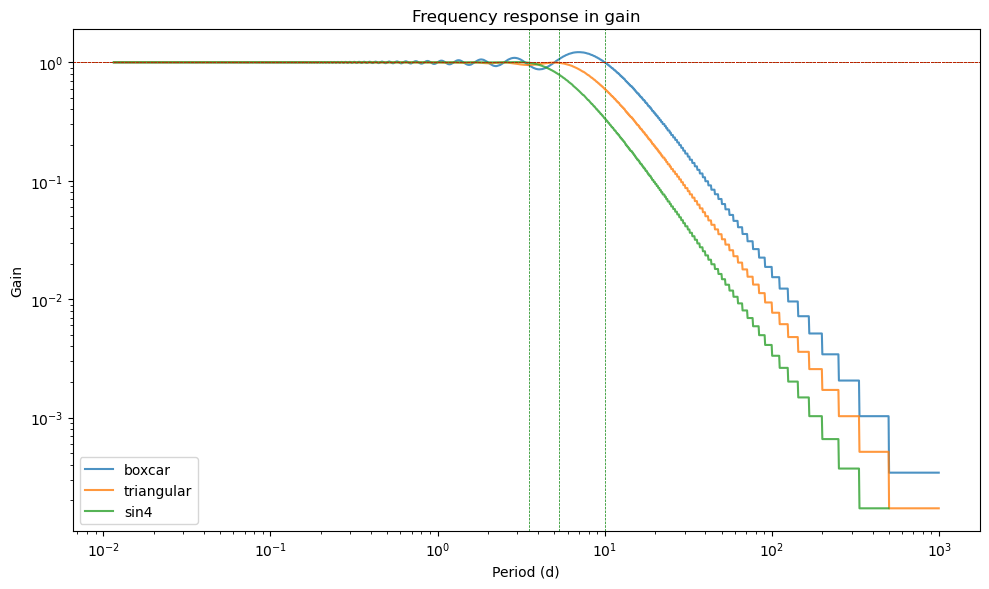

In [4]:
boxcar_passe_haut = lambda flux, window: flux / boxcar_filter(flux, window)
triangulaire_passe_haut = lambda flux, window: flux / triangular_filter(flux, window)
sin4_passe_haut = lambda flux, window: flux / sin4_filter(flux, window)

test_func = lambda x: 1 + .2*np.sin(x)

ax = test_filter(boxcar_passe_haut, test_func=test_func, label="boxcar", find_freq_ascending=True)
test_filter(triangulaire_passe_haut, test_func=test_func, ax=ax, label="triangular", find_freq_ascending=True)
test_filter(sin4_passe_haut, test_func=test_func, ax=ax, label="sin4", find_freq_ascending=True)

On peut enfin tester les valeurs trouvées (qui sont utilisées par défaut dans Lobster), en affichant les PSD sans filtrage puis avec chacun des 6 filtrages testés.

La courbe de lumière et les correction effectuées aux premières lignes sont arbitraires afin d'obtenir une PSD lisible, mais un quelconque signal donnera le même résultat.

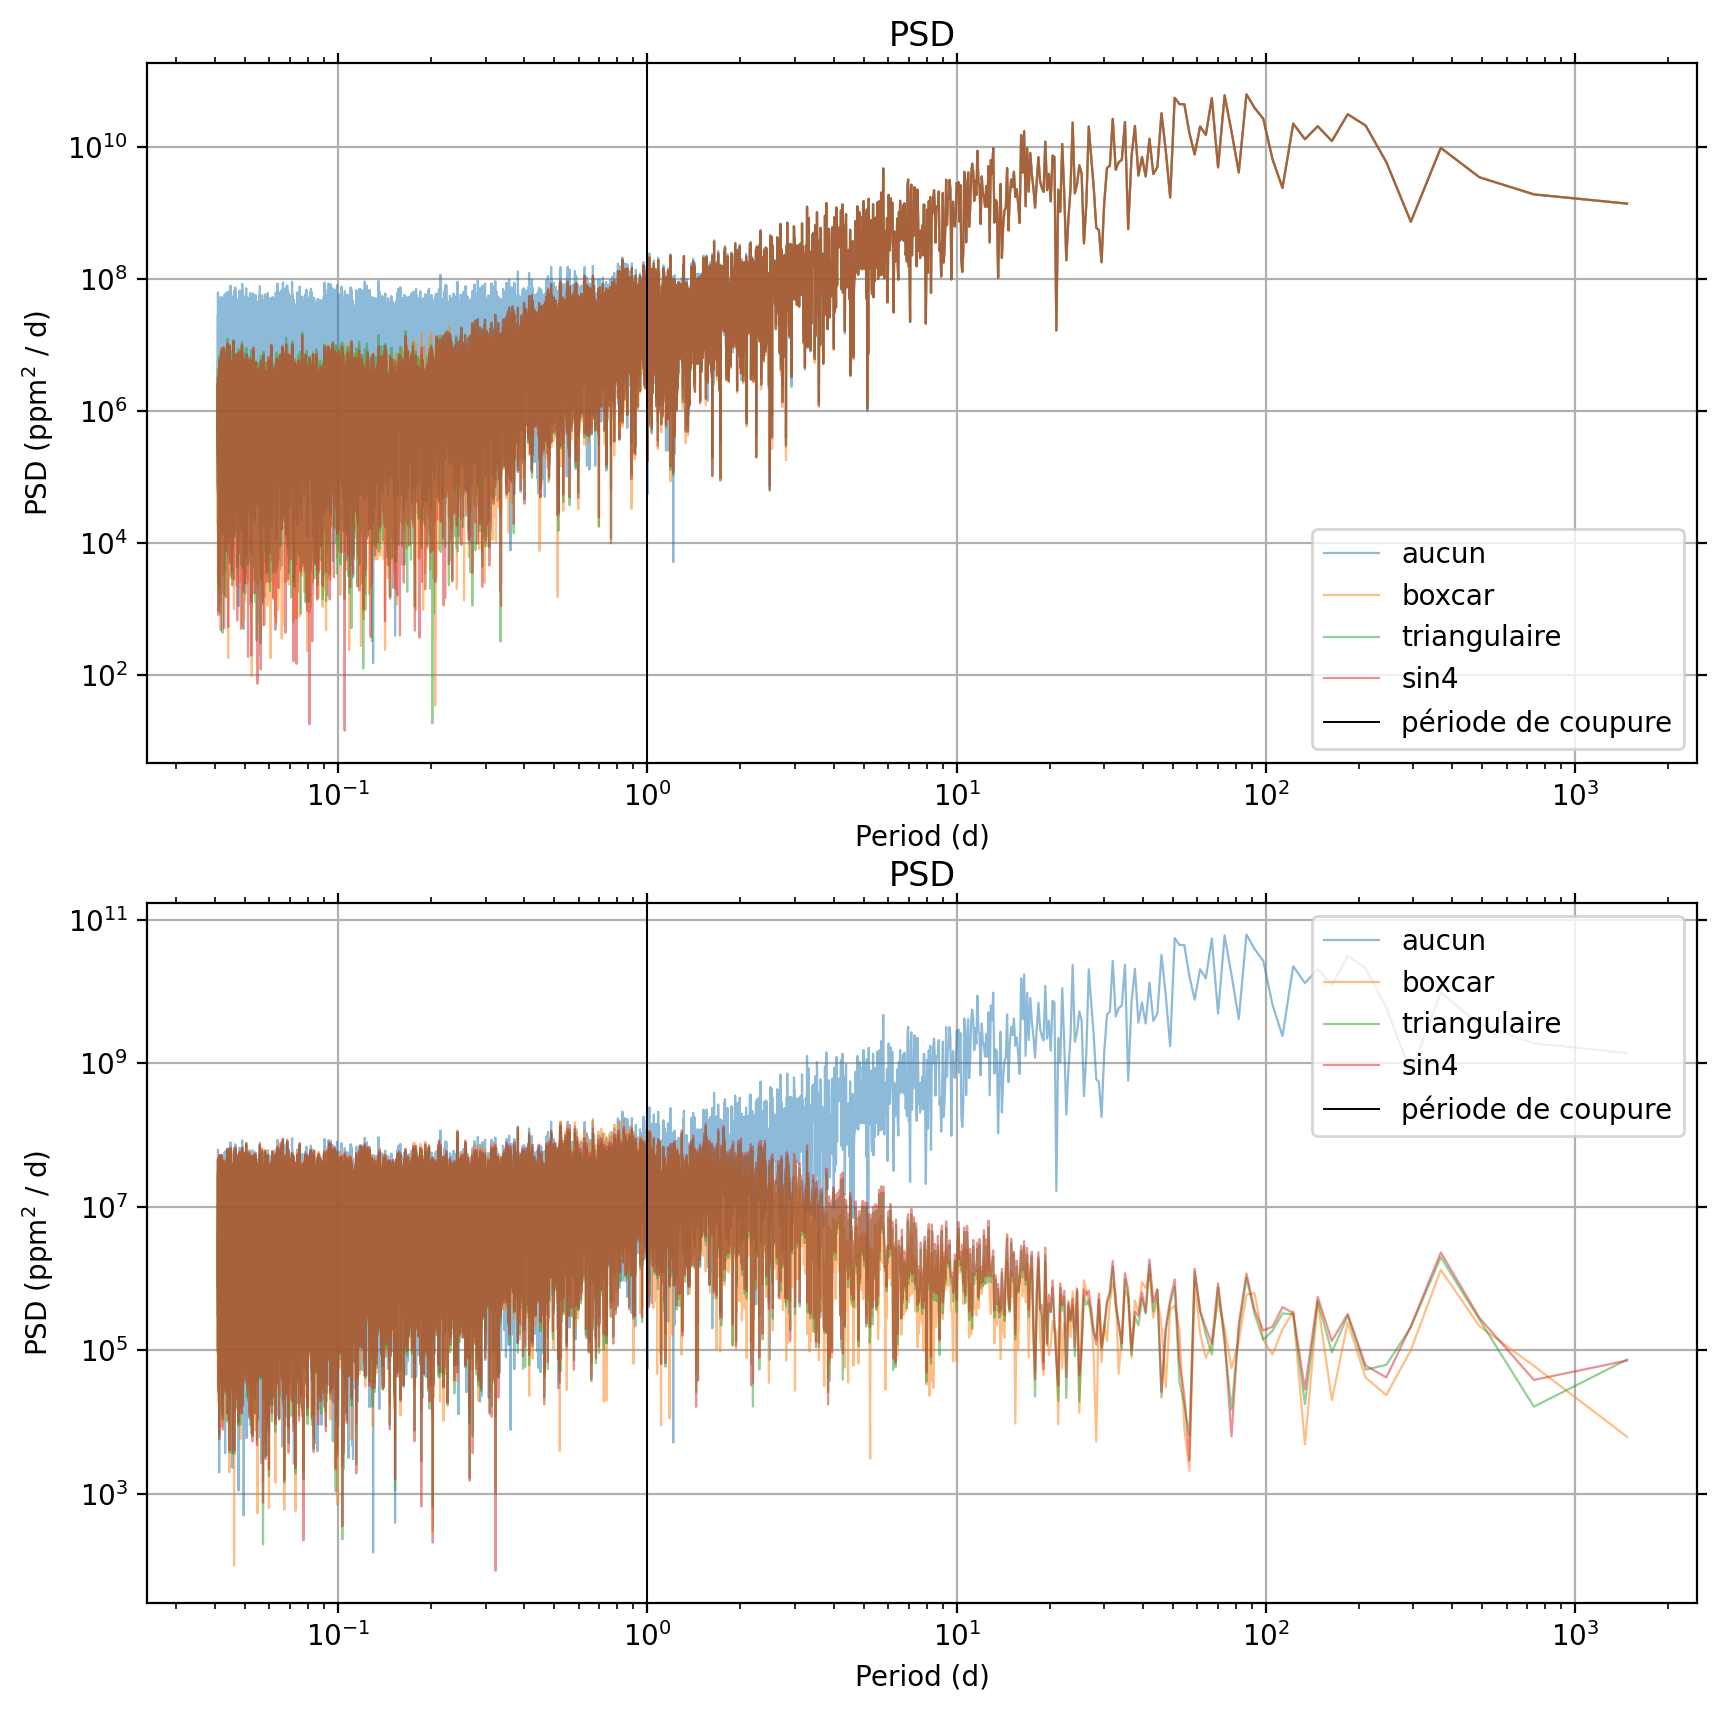

In [7]:
lc = Lightcurve("../../kbonus/data/0007/000757052/hlsp_kbonus-bkg_kepler_kepler_kic-000757052_kepler_v1.0_lc.fits")
lc.remove_invalids()
lc.find_jumps_in_time()
lc.stitch()
lc.normalize_adaptative_sin4_filter()
lc.rescale_sections()
lc.remove_outliers()
lc.resample()

fig, (ax1, ax2) = plt.subplots(2, figsize=(10,10), dpi=200)

lc.copy().flux_to_ppm().plot_psd(ax=ax1, visualisation="d", label="aucun", alpha=.5, title="PSD passe-bas")
lc.copy().smooth_boxcar_filter(cut_below_period=1).flux_to_ppm().plot_psd(ax=ax1, visualisation="d", label="boxcar", alpha=.5)
lc.copy().smooth_triangular_filter(cut_below_period=1).flux_to_ppm().plot_psd(ax=ax1, visualisation="d", label="triangulaire", alpha=.5)
lc.copy().smooth_sin4_filter(cut_below_period=1).flux_to_ppm().plot_psd(ax=ax1, visualisation="d", label="sin4", alpha=.5)
ax1.axvline(x=1, label="période de coupure", c="black", lw=.7)
ax1.legend()

lc.copy().flux_to_ppm().plot_psd(ax=ax2, visualisation="d", label="aucun", alpha=.5, title="PSD passe-haut")
lc.copy().normalize_boxcar_filter(cut_above_period=1).flux_to_ppm().plot_psd(ax=ax2, visualisation="d", label="boxcar", alpha=.5)
lc.copy().normalize_triangular_filter(cut_above_period=1).flux_to_ppm().plot_psd(ax=ax2, visualisation="d", label="triangulaire", alpha=.5)
lc.copy().normalize_sin4_filter(cut_above_period=1).flux_to_ppm().plot_psd(ax=ax2, visualisation="d", label="sin4", alpha=.5)
ax2.axvline(x=1, label="période de coupure", c="black", lw=.7)
ax2.legend()